In [1]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1wMDi6CGCkoBLKwMv1YERVGAIljXzDXxT"})   # ID of file you want to access
downloaded.GetContentFile('data.csv')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from datetime import datetime, date, timedelta


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping 
from keras.layers.normalization import BatchNormalization

import math

import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head()

,Datetime,feed_flow,product_flow,feed_concentration,product_concentration,feed_temperature,stage_1_feed_pressure,product_pressure,stage_2_feed_pressure,stage_3_feed_pressure,reject_pressure,A,B,k1,k2,k3,salt_loading,recovery,salt_loading_since_replace,salt_loading_since_clean,running_time_since_clean,running_time_since_replace,feed_ph,feed_turbidity
0,2019-06-01 00:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.366667,3935.409545,7.890750,NaN
1,2019-06-01 00:02:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.383333,3935.426212,7.947625,NaN
2,2019-06-01 00:03:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.400000,3935.442878,7.890750,NaN
3,2019-06-01 00:04:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.416667,3935.459545,7.914375,NaN
4,2019-06-01 00:05:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467.433333,3935.476212,7.914375,NaN


In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values(by ='Datetime' )
df.index = df['Datetime']

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 527039 entries, 2019-06-01 00:01:00+00:00 to 2020-05-31 23:59:00+00:00
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   Datetime                    527039 non-null  datetime64[ns, UTC]
 1   feed_flow                   152075 non-null  float64            
 2   product_flow                152075 non-null  float64            
 3   feed_concentration          152075 non-null  float64            
 4   product_concentration       152075 non-null  float64            
 5   feed_temperature            152075 non-null  float64            
 6   stage_1_feed_pressure       152075 non-null  float64            
 7   product_pressure            152075 non-null  float64            
 8   stage_2_feed_pressure       152075 non-null  float64            
 9   stage_3_feed_pressure       152075 non-null  float64            
 10

#### Notice that we have done any data cleaning since this is a time-series data. The data samples have temporal dependency between each other and hence, the ordering/sequence of data points has to be maintained. Hence, we cannot delete or discard the rows which has Null values or are empty.

In [ ]:
# Time-series Forecasting models and Regression models works best when the number of missings values for the features are less. 
# But almost all the features have 71% of its data missing based on the tables above.

# Hence extracting data between a date range which has few missing values.

df2 = df.loc['2020-02-15 00:00:00' : '2020-04-07 00:00:00']

# The data has few missing values only in between the date range of Feb 15th 2021 - April 7th 2021 as shown in the table below

subset = df2[['feed_flow', 'feed_concentration', 'feed_temperature', 'stage_1_feed_pressure','A']]

#Imputing the missing values with '0'

subset['feed_flow'] = subset['feed_flow'].fillna(0)
#subset['feed_flow'].fillna(0)
subset['feed_concentration'] = subset['feed_concentration'].fillna(0)
subset['feed_temperature'] = subset['feed_temperature'].fillna(0)
subset['A'] = subset['A'].fillna(0)
subset['stage_1_feed_pressure'] = subset['stage_1_feed_pressure'].fillna(0)


In [ ]:
subset.reset_index(drop=True)


,feed_flow,feed_concentration,feed_temperature,stage_1_feed_pressure,A
0,0.000000,0.000,0.000000,0.00000,0.000000
1,0.000000,0.000,0.000000,0.00000,0.000000
2,0.000000,0.000,0.000000,0.00000,0.000000
3,0.000000,0.000,0.000000,0.00000,0.000000
4,0.000000,0.000,0.000000,0.00000,0.000000
...,...,...,...,...,...
74876,156.616128,225.720,16.631944,11.52930,0.003856
74877,156.616128,226.440,16.586806,11.56292,0.003849
74878,158.193432,227.115,16.586806,11.63014,0.003838
74879,157.557132,227.430,16.572917,11.63014,0.003819


### Building time-series forecasting LSTM model for univariate data using the - Stage_1_feed_pressure' feature and Date range: 15th Feb - 7th April

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 15, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 15, 32)            1

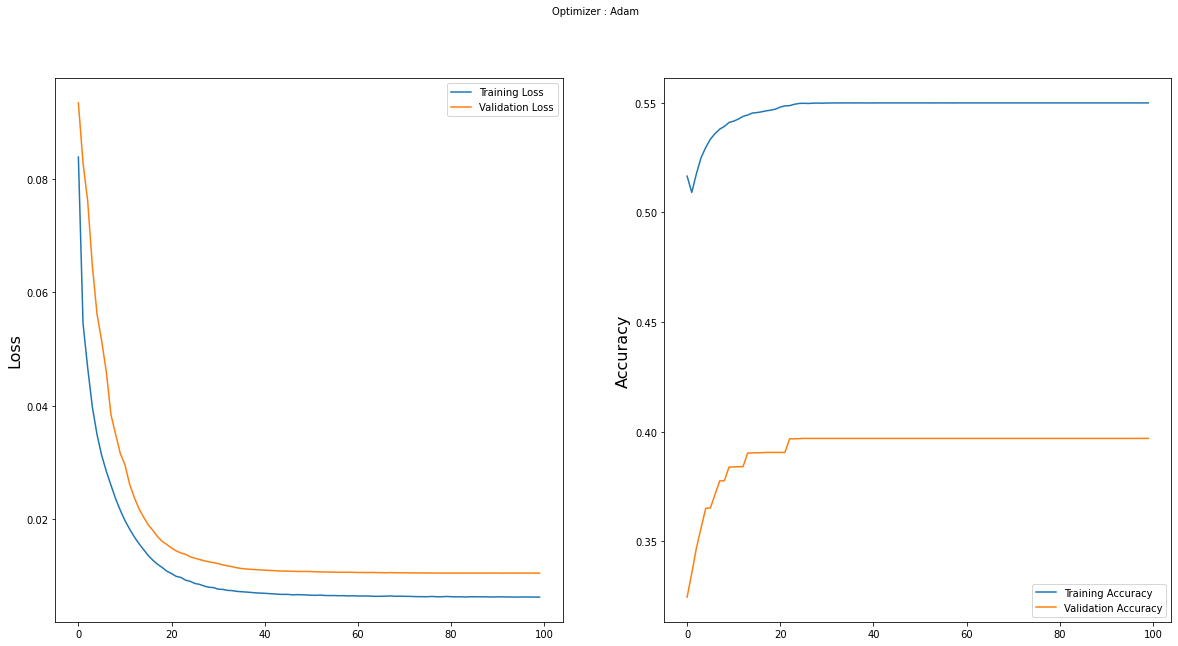

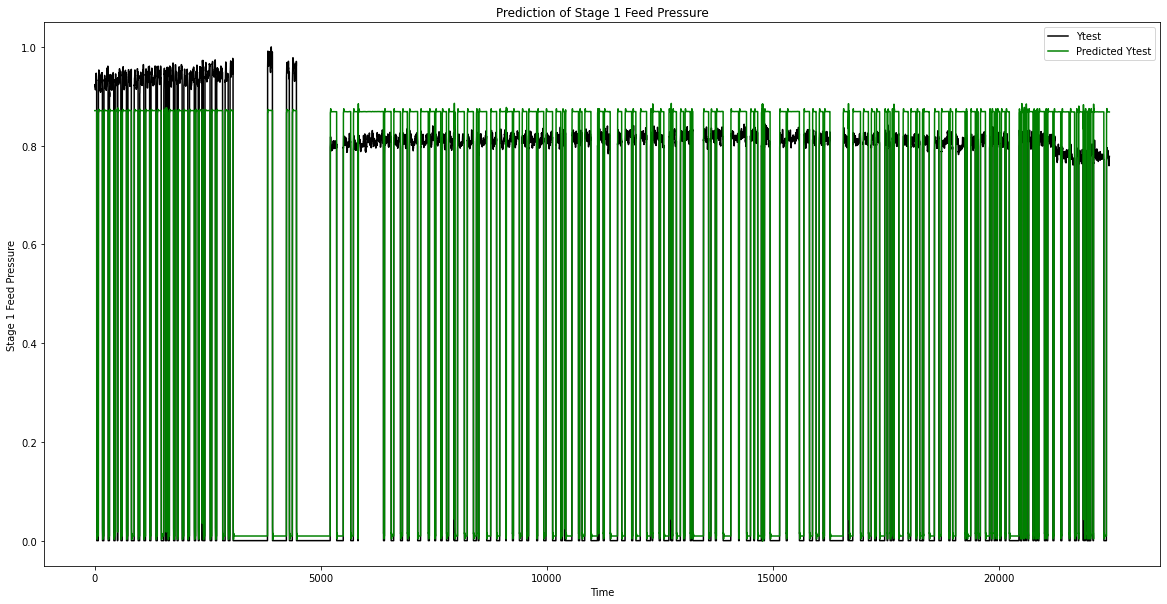

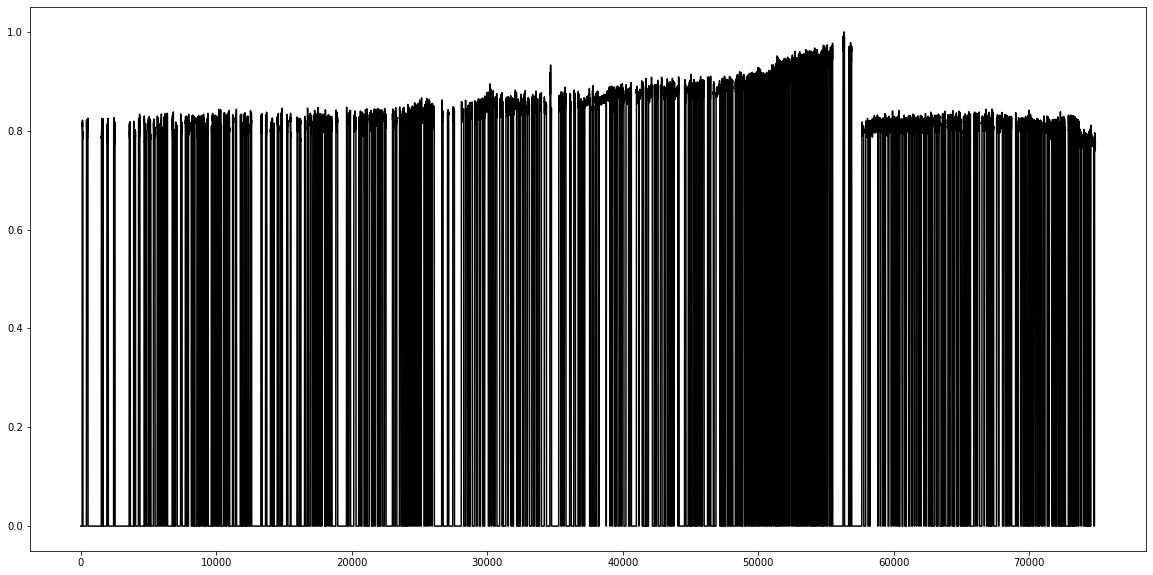

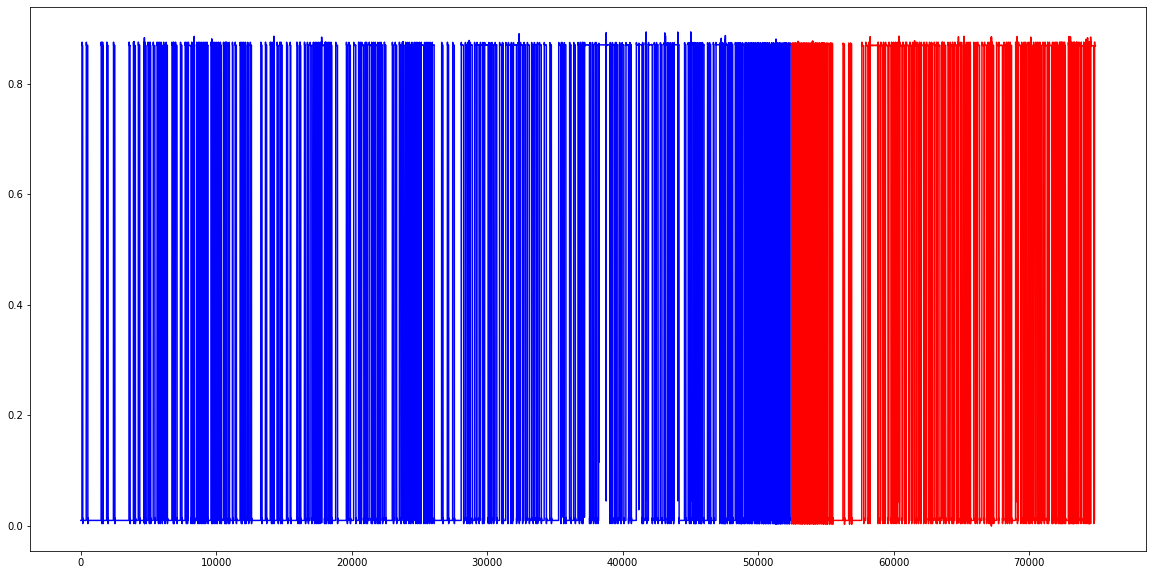

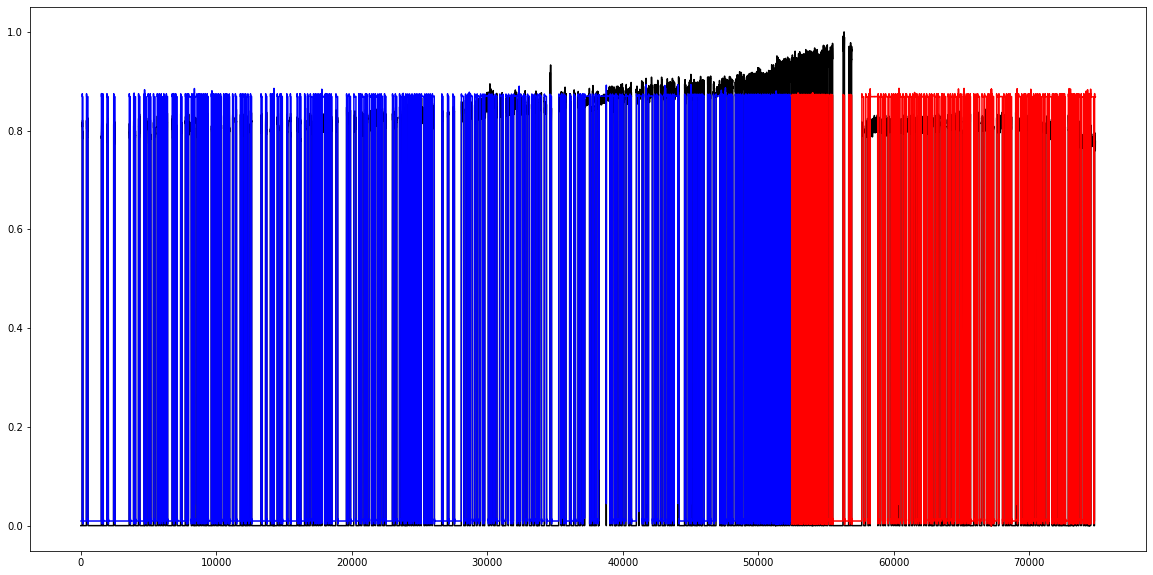

Train Score: 1.32 RMSE
Test Score: 1.63 RMSE


In [ ]:
#Time-series Forecasting

def LSTM_Stage_FPressure_Univariate(subset):
    np.random.seed(1)
    df_stg = subset[['stage_1_feed_pressure']]
    
    #Normalize the 'stage_1_feed_pressure' feature using Minmax Normalization
    minmax_scale = MinMaxScaler().fit(df_stg[['stage_1_feed_pressure']])
    df_stg['minmax_stage_fpressure'] = minmax_scale.transform(df_stg[['stage_1_feed_pressure']])
    
    #Dataframe column into series of values
    entire_dataset = df_stg['minmax_stage_fpressure'].values

    #Change the shape of the series from 1D array to 2D array
    entire_dataset = entire_dataset.reshape(-1,1)

    #Previous 15(look_back) timetseps used to predict next 1 time step(pred_length). 
    # Past 15 mintues values to predict next 1 minute value
    look_back = 15
    pred_length = 1
    dataset_len = len(entire_dataset)

    #split the dataset into train & text in the ratio of 70:30
    train_size = int(dataset_len * 0.70)
    test_size = dataset_len - train_size
    train, test = entire_dataset[0:train_size,:], entire_dataset[train_size:dataset_len,:]

    #Covert into supervised problem. Input -> Output using Sequence of previous 
    #time steps to generate future time steps
    # Eg. T1, T2, T3 -> T4
    #     T2, T3, T4 -> T5
    def create_subSeq(dataseries, look_back, pred_length):
        ip, op = [], []
        for i in range(len(dataseries)):
            ip_index = i + look_back
            op_index = ip_index + pred_length
            if(op_index > len(dataseries)):
                break
            seq_x, seq_y = dataseries[i:ip_index], dataseries[ip_index:op_index]
            ip.append(seq_x)
            op.append(seq_y)
        return np.array(ip), np.array(op)


    X_train, Y_train = create_subSeq(train, look_back, pred_length)
    X_test, Y_test = create_subSeq(test, look_back, pred_length)

    
    # reshape from [samples, timesteps] into [samples, timesteps, features]-> 3D array as input to LSTM
    # sample = number of samples, timesteps= look_back, features = 1 (stage__feed_pressure)
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

    #reshape Y's as [samples, timesteps]-> samples, pred_length
    Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1]))
    Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))

    #Build model
    model = Sequential()
    model.add(LSTM(256,activation ='tanh', input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(128,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(32,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(16,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(8))
    model.add(Dense(pred_length))

    adam = keras.optimizers.Adam(lr=0.0001)

    model.compile(loss='mean_squared_error',optimizer=adam,metrics=['accuracy'])
    model.summary()

    history = model.fit(X_train, Y_train, epochs=100, batch_size=256, validation_split=0.2,verbose=2,shuffle=False)

    # Visulaize training and validation loss plots

    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    #Prediction of Y_train and Y_test
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)

    #Compare actual Ytrain, Ytest with predicted Ytrain & Ytest
    # %matplotlib inline

    plt.figure(figsize=(20,10))
    plt.plot(Y_test, color = 'black', label = 'Ytest')
    plt.plot(testPredict, color = 'green', label = 'Predicted Ytest')
    plt.title('Prediction of Stage 1 Feed Pressure')
    plt.xlabel('Time')
    plt.ylabel('Stage 1 Feed Pressure')
    plt.legend()
    plt.show(block = False)
    

    #Plot the Forecasted values overlapped on top of Actual values of Stage_1_feed_pressure data(normalized)
    trainPredictPlot = np.empty_like(entire_dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    testPredictPlot = np.empty_like(entire_dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2):len(entire_dataset), :] = testPredict

    plt.figure(figsize=(20,10))
    plt.plot(entire_dataset, color = 'black',label = 'Stage1 feed pressure(Actual)')
    plt.show(block = False)

    plt.figure(figsize=(20,10))
    plt.plot(trainPredictPlot, color = 'blue', label = 'Stage1 feed pressure(Trained)')
    plt.plot(testPredictPlot, color = 'red', label = 'Stage1 feed pressure(Tested)')
    plt.show(block = False)

    plt.figure(figsize=(20,10))
    plt.plot(entire_dataset, color = 'black')
    plt.plot(trainPredictPlot, color = 'blue')
    plt.plot(testPredictPlot, color = 'red', label = 'Stage1 feed pressure(Predicted)')
    plt.show(block = False)


    trainPredict = minmax_scale.inverse_transform(trainPredict)
    trainY = minmax_scale.inverse_transform(Y_train)
    testPredict = minmax_scale.inverse_transform(testPredict)
    testY = minmax_scale.inverse_transform(Y_test)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))


# Invoking the LSTM model building for univariate stage1_feed_pressure predictions
LSTM_Stage_FPressure_Univariate(subset)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 15, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 15, 32)            1

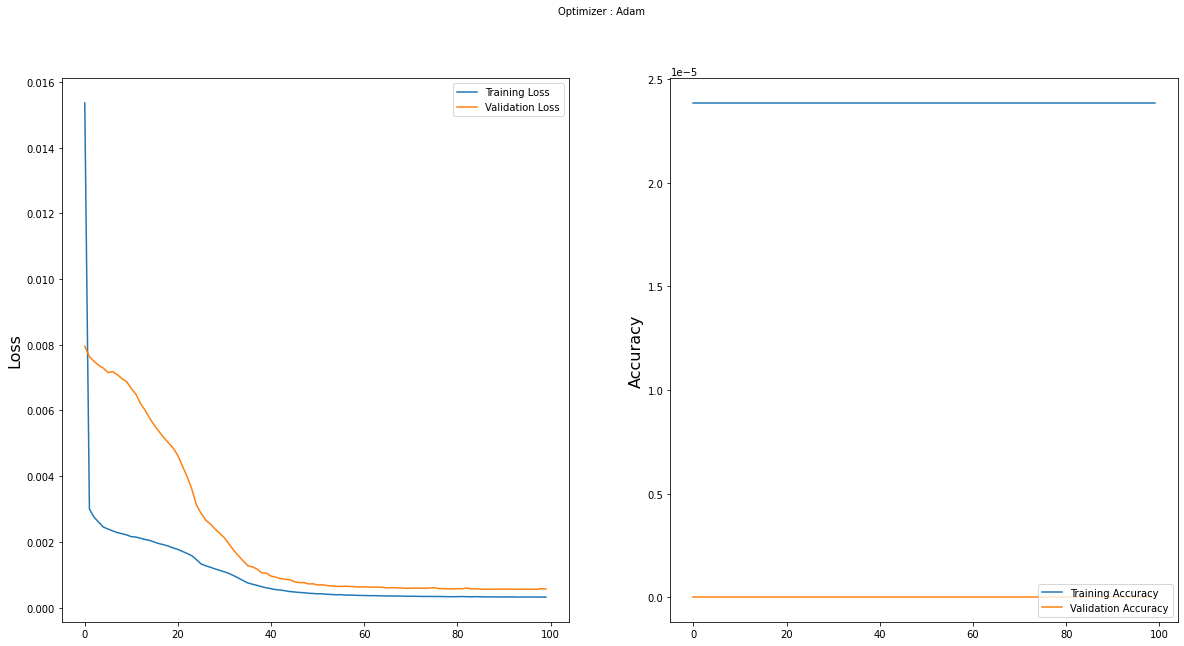

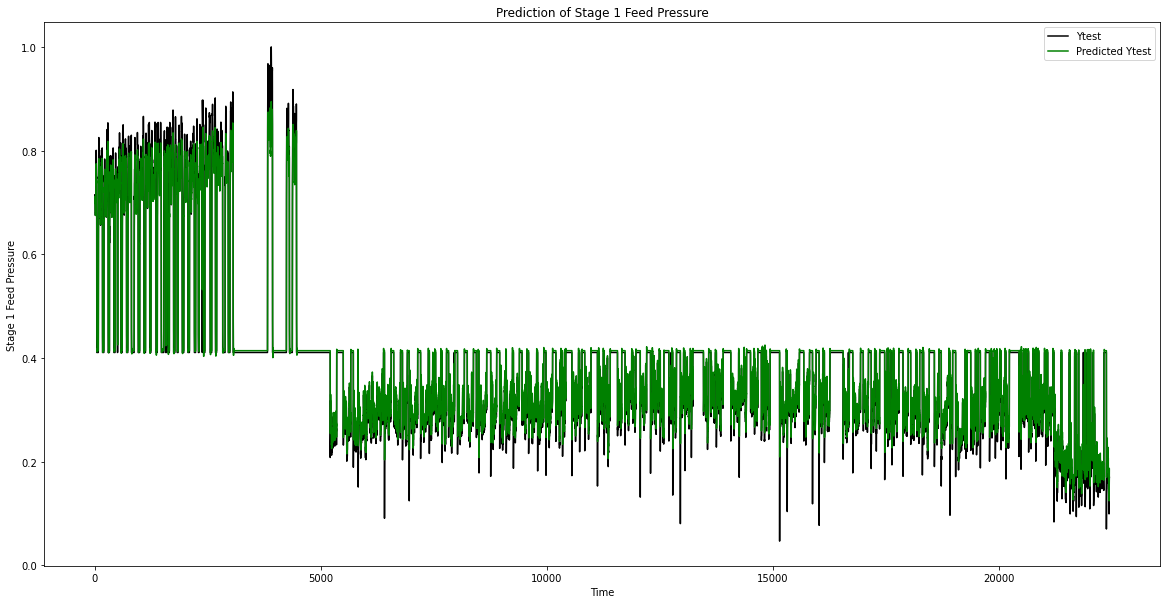

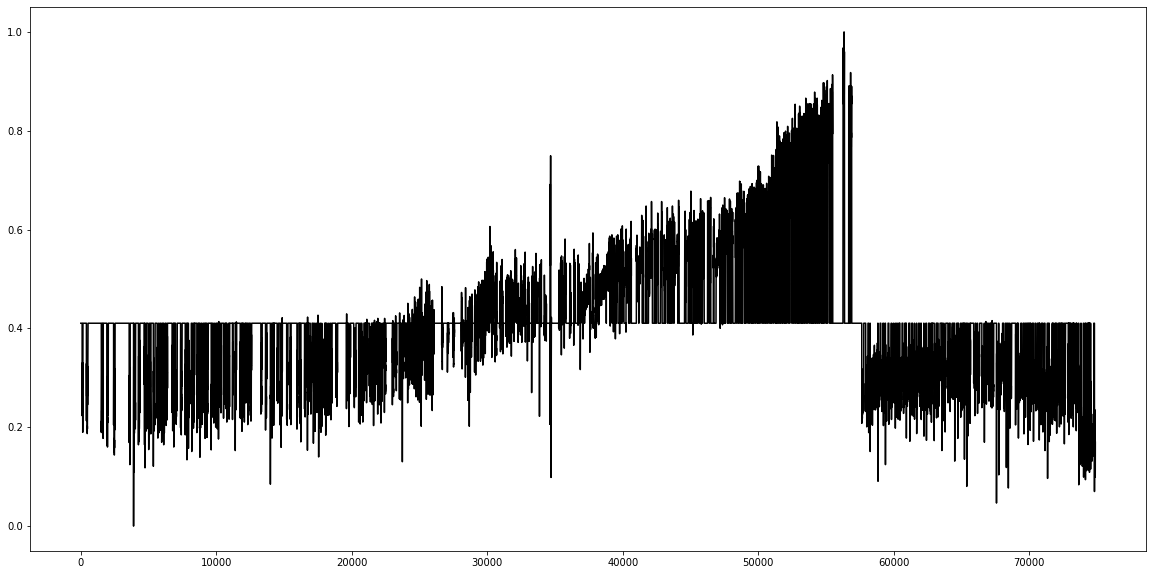

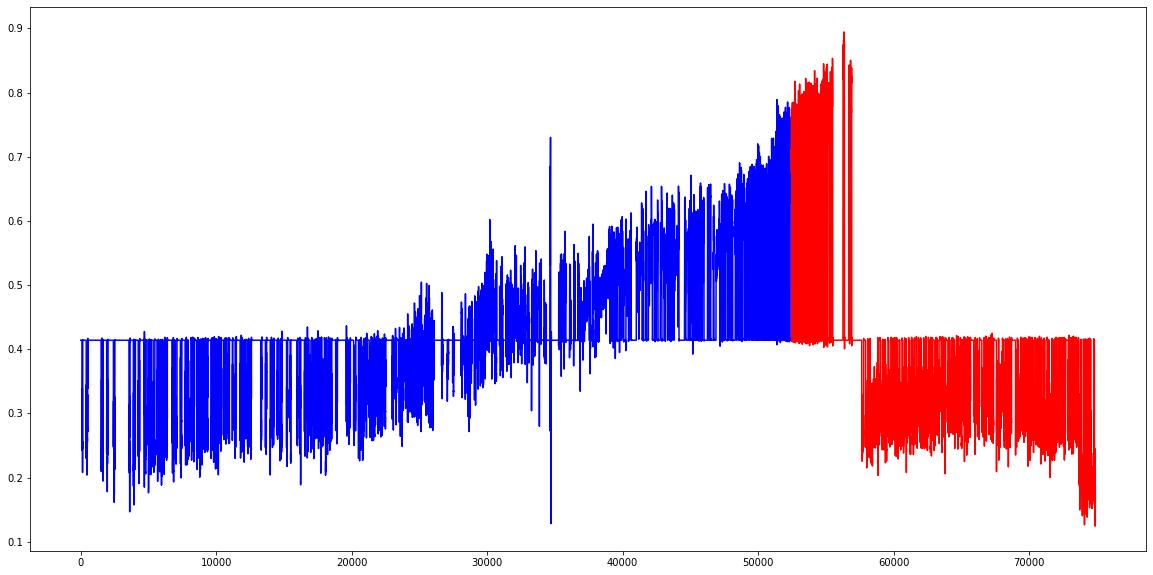

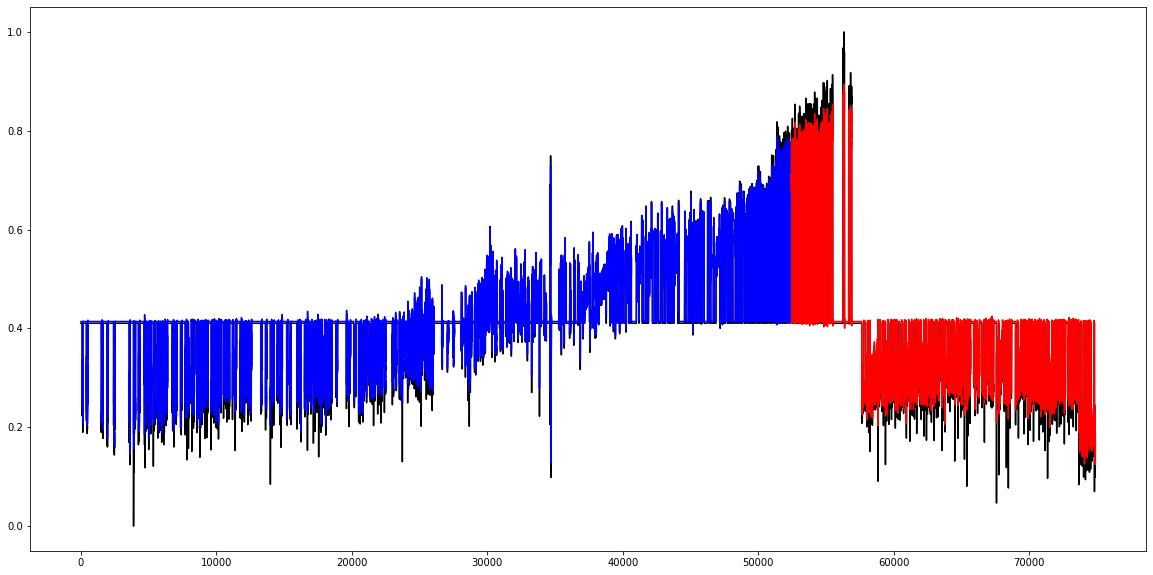

Train Score: 0.07 RMSE
Test Score: 0.12 RMSE


In [ ]:
# Time-series Forecasting models and Regression models works best when the number of missings values for the features are less. 
# But almost all the features have 71% of its data missing based on the tables above.

# Hence extracting data between a date range which has few missing values.

df2 = df.loc['2020-02-15 00:00:00' : '2020-04-07 00:00:00']

# The data has few missing values only in between the date range of Feb 15th 2021 - April 7th 2021 as shown in the table below

subset = df2[['feed_flow', 'feed_concentration', 'feed_temperature', 'stage_1_feed_pressure','A']]

#Imputing the missing values with mean values

subset['feed_flow'] = subset['feed_flow'].fillna(subset['feed_flow'].mean())
subset['feed_concentration'] = subset['feed_concentration'].fillna(subset['feed_concentration'].mean())
subset['feed_temperature'] = subset['feed_temperature'].fillna(subset['feed_temperature'].mean())
subset['A'] = subset['A'].fillna(subset['A'].mean())
subset['stage_1_feed_pressure'] = subset['stage_1_feed_pressure'].fillna(subset['stage_1_feed_pressure'].mean())

subset.reset_index(drop=True)

#Time-series Forecasting

def LSTM_Stage_FPressure_Univariate(subset):
    np.random.seed(1)
    df_stg = subset[['stage_1_feed_pressure']]
    
    #Normalize the 'stage_1_feed_pressure' feature using Minmax Normalization
    minmax_scale = MinMaxScaler().fit(df_stg[['stage_1_feed_pressure']])
    df_stg['minmax_stage_fpressure'] = minmax_scale.transform(df_stg[['stage_1_feed_pressure']])
    
    #Dataframe column into series of values
    entire_dataset = df_stg['minmax_stage_fpressure'].values

    #Change the shape of the series from 1D array to 2D array
    entire_dataset = entire_dataset.reshape(-1,1)

    #Previous 15(look_back) timetseps used to predict next 1 time step(pred_length). 
    # Past 15 mintues values to predict next 1 minute value
    look_back = 15
    pred_length = 1
    dataset_len = len(entire_dataset)

    #split the dataset into train & text in the ratio of 70:30
    train_size = int(dataset_len * 0.70)
    test_size = dataset_len - train_size
    train, test = entire_dataset[0:train_size,:], entire_dataset[train_size:dataset_len,:]

    #Covert into supervised problem. Input -> Output using Sequence of previous 
    #time steps to generate future time steps
    # Eg. T1, T2, T3 -> T4
    #     T2, T3, T4 -> T5
    def create_subSeq(dataseries, look_back, pred_length):
        ip, op = [], []
        for i in range(len(dataseries)):
            ip_index = i + look_back
            op_index = ip_index + pred_length
            if(op_index > len(dataseries)):
                break
            seq_x, seq_y = dataseries[i:ip_index], dataseries[ip_index:op_index]
            ip.append(seq_x)
            op.append(seq_y)
        return np.array(ip), np.array(op)


    X_train, Y_train = create_subSeq(train, look_back, pred_length)
    X_test, Y_test = create_subSeq(test, look_back, pred_length)

    
    # reshape from [samples, timesteps] into [samples, timesteps, features]-> 3D array as input to LSTM
    # sample = number of samples, timesteps= look_back, features = 1 (stage__feed_pressure)
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

    #reshape Y's as [samples, timesteps]-> samples, pred_length
    Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1]))
    Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))

    #Build model
    model = Sequential()
    model.add(LSTM(256,activation ='tanh', input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(128,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(32,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(16,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(8))
    model.add(Dense(pred_length))

    adam = keras.optimizers.Adam(lr=0.0001)

    model.compile(loss='mean_squared_error',optimizer=adam,metrics=['accuracy'])
    model.summary()

    history = model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_split=0.2,verbose=2,shuffle=False)

    # Visulaize training and validation loss plots

    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    #Prediction of Y_train and Y_test
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)

    #Compare actual Ytrain, Ytest with predicted Ytrain & Ytest
    # %matplotlib inline

    plt.figure(figsize=(20,10))
    plt.plot(Y_test, color = 'black', label = 'Ytest')
    plt.plot(testPredict, color = 'green', label = 'Predicted Ytest')
    plt.title('Prediction of Stage 1 Feed Pressure')
    plt.xlabel('Time')
    plt.ylabel('Stage 1 Feed Pressure')
    plt.legend()
    plt.show(block = False)
    

    #Plot the Forecasted values overlapped on top of Actual values of Stage_1_feed_pressure data(normalized)
    trainPredictPlot = np.empty_like(entire_dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    testPredictPlot = np.empty_like(entire_dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2):len(entire_dataset), :] = testPredict

    plt.figure(figsize=(20,10))
    plt.plot(entire_dataset, color = 'black',label = 'Stage1 feed pressure(Actual)')
    plt.show(block = False)

    plt.figure(figsize=(20,10))
    plt.plot(trainPredictPlot, color = 'blue', label = 'Stage1 feed pressure(Trained)')
    plt.plot(testPredictPlot, color = 'red', label = 'Stage1 feed pressure(Tested)')
    plt.show(block = False)

    plt.figure(figsize=(20,10))
    plt.plot(entire_dataset, color = 'black')
    plt.plot(trainPredictPlot, color = 'blue')
    plt.plot(testPredictPlot, color = 'red', label = 'Stage1 feed pressure(Predicted)')
    plt.show(block = False)

    trainPredict = minmax_scale.inverse_transform(trainPredict)
    trainY = minmax_scale.inverse_transform(Y_train)
    testPredict = minmax_scale.inverse_transform(testPredict)
    testY = minmax_scale.inverse_transform(Y_test)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

# Invoking the LSTM model building for univariate stage1_feed_pressure predictions
LSTM_Stage_FPressure_Univariate(subset)


In [6]:

df2 = df.loc['2020-02-15 00:00:00' : '2020-04-07 00:00:00']

# The data has few missing values only in between the date range of Feb 15th 2021 - April 7th 2021 as shown in the table below

subset = df2[['feed_flow', 'feed_concentration', 'feed_temperature', 'stage_1_feed_pressure','A']]

#Imputing the missing values with mean values

subset['feed_flow'] = subset['feed_flow'].fillna(subset['feed_flow'].mean())
subset['feed_concentration'] = subset['feed_concentration'].fillna(subset['feed_concentration'].mean())
subset['feed_temperature'] = subset['feed_temperature'].fillna(subset['feed_temperature'].mean())
subset['A'] = subset['A'].fillna(subset['A'].mean())
subset['stage_1_feed_pressure'] = subset['stage_1_feed_pressure'].fillna(subset['stage_1_feed_pressure'].mean())

subset.reset_index(drop=True)

,feed_flow,feed_concentration,feed_temperature,stage_1_feed_pressure,A
0,161.755800,223.349679,16.318117,12.59152,0.003732
1,161.755800,223.349679,16.318117,12.59152,0.003732
2,161.755800,223.349679,16.318117,12.59152,0.003732
3,161.755800,223.349679,16.318117,12.59152,0.003732
4,161.755800,223.349679,16.318117,12.59152,0.003732
...,...,...,...,...,...
74876,156.616128,225.720000,16.631944,11.52930,0.003856
74877,156.616128,226.440000,16.586806,11.56292,0.003849
74878,158.193432,227.115000,16.586806,11.63014,0.003838
74879,157.557132,227.430000,16.572917,11.63014,0.003819


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 15, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 15, 32)            1

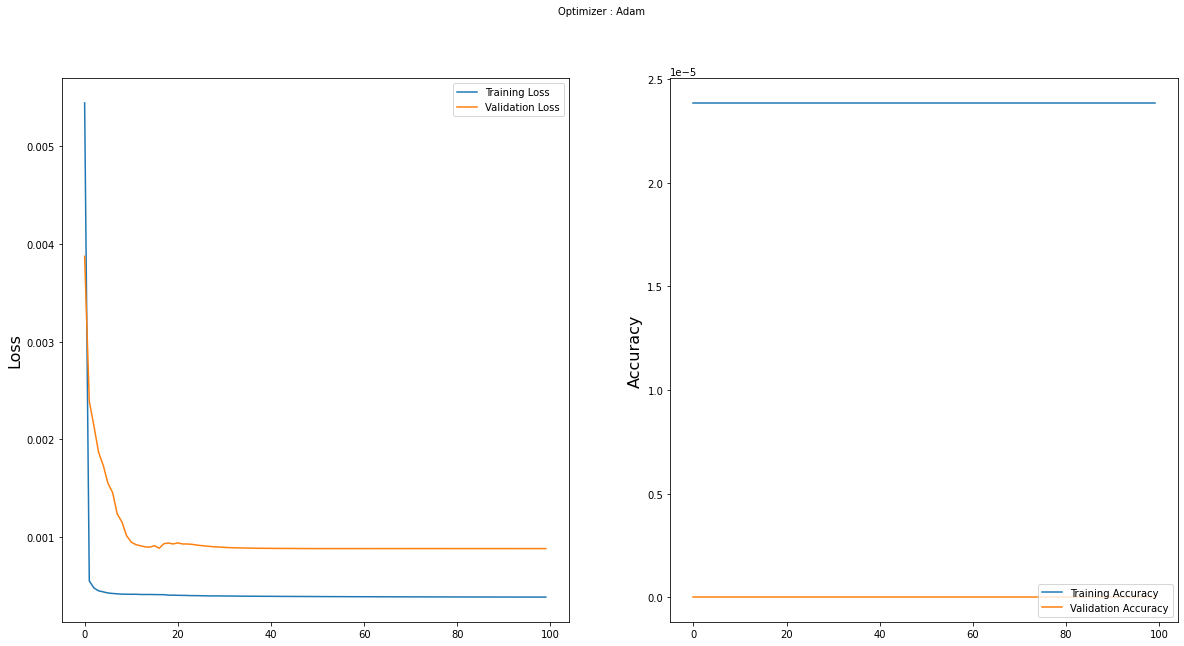

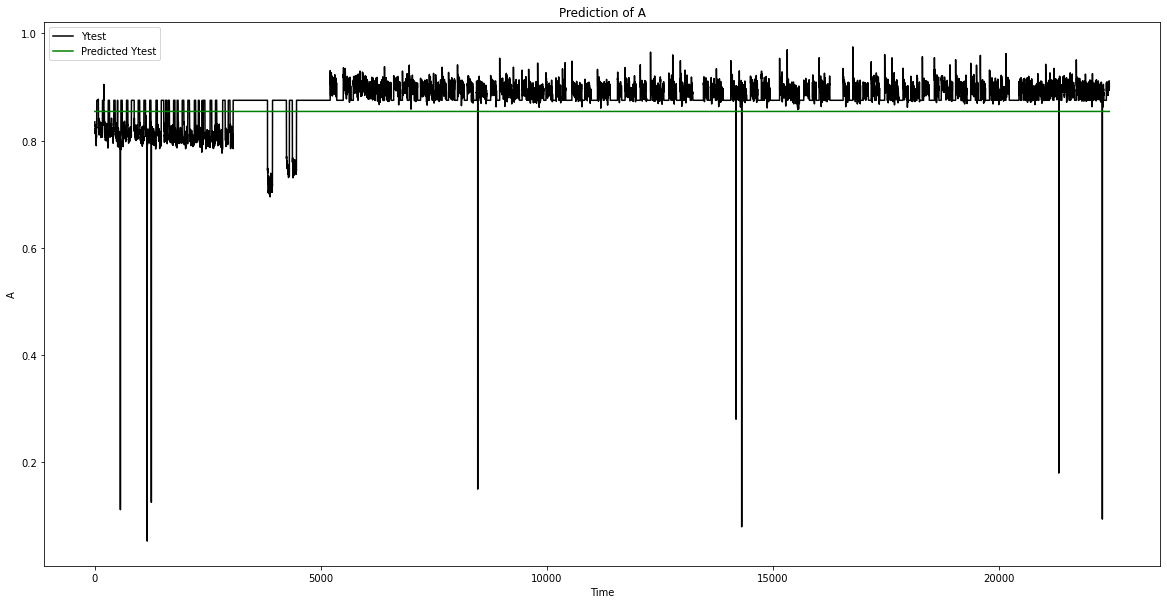

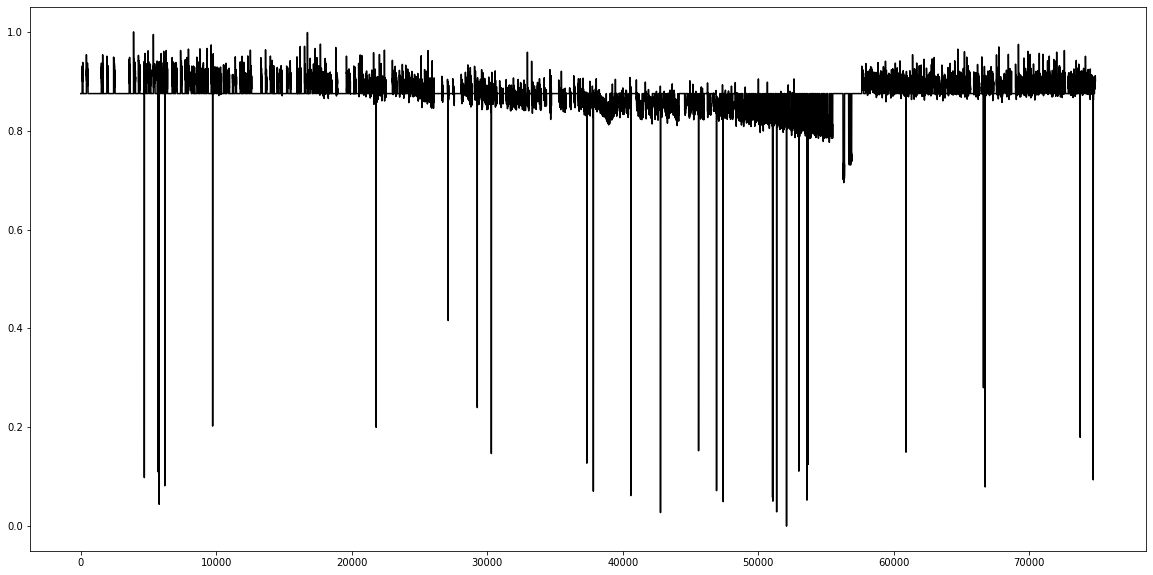

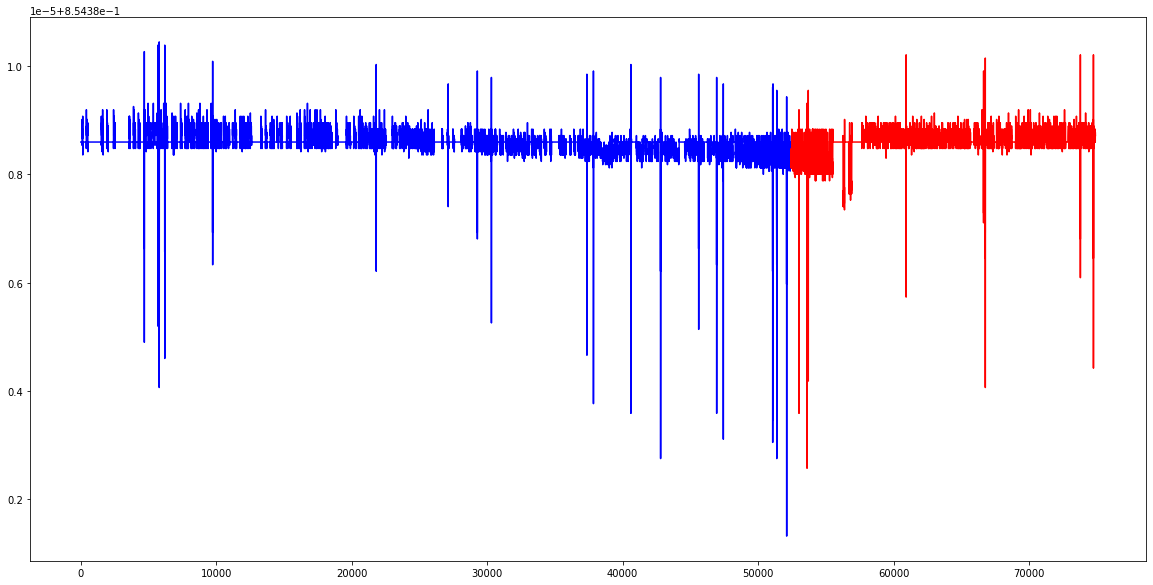

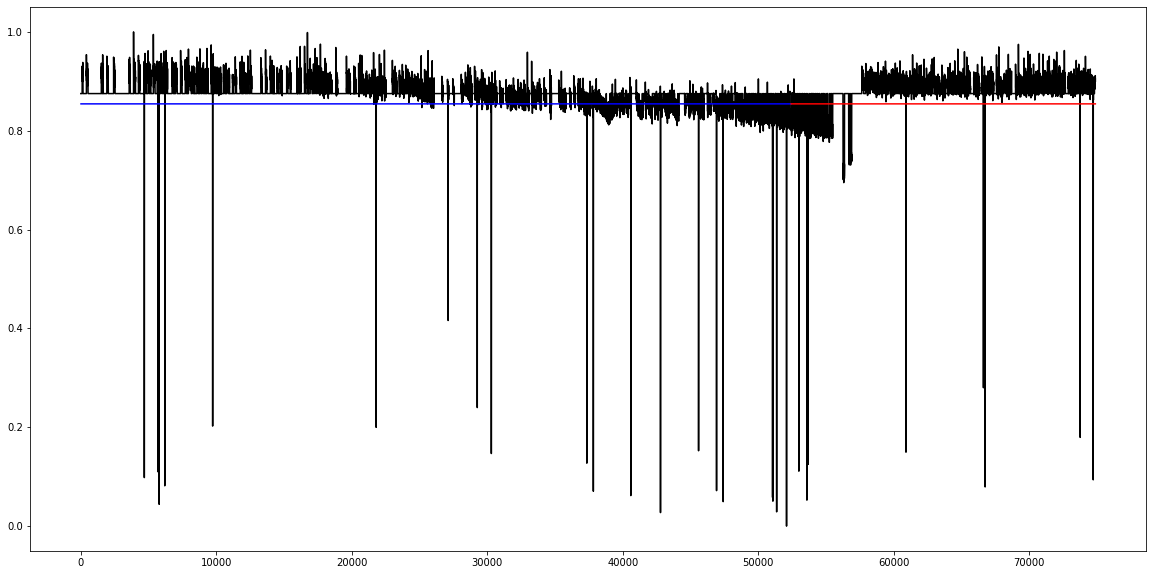

Train Score: 0.00 RMSE
Test Score: 0.00 RMSE


In [7]:
#Time-series Forecasting
#For 'A' after imputing missing values with mean values of features

def LSTM_A_Univariate(subset):
    np.random.seed(1)
    df_stg = subset[['A']]
    
    #Normalize the 'stage_1_feed_pressure' feature using Minmax Normalization
    minmax_scale = MinMaxScaler().fit(df_stg[['A']])
    df_stg['minmax_A'] = minmax_scale.transform(df_stg[['A']])
    
    #Dataframe column into series of values
    entire_dataset = df_stg['minmax_A'].values

    #Change the shape of the series from 1D array to 2D array
    entire_dataset = entire_dataset.reshape(-1,1)

    #Previous 15(look_back) timetseps used to predict next 1 time step(pred_length). 
    # Past 15 mintues values to predict next 1 minute value
    look_back = 15
    pred_length = 1
    dataset_len = len(entire_dataset)

    #split the dataset into train & text in the ratio of 70:30
    train_size = int(dataset_len * 0.70)
    test_size = dataset_len - train_size
    train, test = entire_dataset[0:train_size,:], entire_dataset[train_size:dataset_len,:]

    #Covert into supervised problem. Input -> Output using Sequence of previous 
    #time steps to generate future time steps
    # Eg. T1, T2, T3 -> T4
    #     T2, T3, T4 -> T5
    def create_subSeq(dataseries, look_back, pred_length):
        ip, op = [], []
        for i in range(len(dataseries)):
            ip_index = i + look_back
            op_index = ip_index + pred_length
            if(op_index > len(dataseries)):
                break
            seq_x, seq_y = dataseries[i:ip_index], dataseries[ip_index:op_index]
            ip.append(seq_x)
            op.append(seq_y)
        return np.array(ip), np.array(op)




    X_train, Y_train = create_subSeq(train, look_back, pred_length)
    X_test, Y_test = create_subSeq(test, look_back, pred_length)

    
    # reshape from [samples, timesteps] into [samples, timesteps, features]-> 3D array as input to LSTM
    # sample = number of samples, timesteps= look_back, features = 1 (stage__feed_pressure)
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

    #reshape Y's as [samples, timesteps]-> samples, pred_length
    Y_train = Y_train.reshape((Y_train.shape[0], Y_train.shape[1]))
    Y_test = Y_test.reshape((Y_test.shape[0], Y_test.shape[1]))

    #Build model
    model = Sequential()
    model.add(LSTM(256,activation ='tanh', input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(128,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(64,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(32,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(16,activation ='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(8))
    model.add(Dense(pred_length))

    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    model.summary()

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    #history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.2,verbose=2,shuffle=False,callbacks=[es])
    history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_split=0.2,verbose=2,shuffle=False)

    # Visulaize training and validation loss plots

    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    #Prediction of Y_train and Y_test
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)

    #Compare actual Ytrain, Ytest with predicted Ytrain & Ytest
    # %matplotlib inline

    plt.figure(figsize=(20,10))
    plt.plot(Y_test, color = 'black', label = 'Ytest')
    plt.plot(testPredict, color = 'green', label = 'Predicted Ytest')
    plt.title('Prediction of A')
    plt.xlabel('Time')
    plt.ylabel('A')
    plt.legend()
    plt.show(block = False)
    

    #Plot the Forecasted values overlapped on top of Actual values of Average Response Time data(normalized)
    trainPredictPlot = np.empty_like(entire_dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    testPredictPlot = np.empty_like(entire_dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2):len(entire_dataset), :] = testPredict

    plt.figure(figsize=(20,10))
    plt.plot(entire_dataset, color = 'black',label = 'A (Actual)')
    plt.show(block = False)

    plt.figure(figsize=(20,10))
    plt.plot(trainPredictPlot, color = 'blue', label = 'A (Trained)')
    plt.plot(testPredictPlot, color = 'red', label = 'A (Tested)')
    plt.show(block = False)

    plt.figure(figsize=(20,10))
    plt.plot(entire_dataset, color = 'black')
    plt.plot(trainPredictPlot, color = 'blue')
    plt.plot(testPredictPlot, color = 'red', label = 'A (Predicted)')
    plt.show(block = False)

    trainPredict = minmax_scale.inverse_transform(trainPredict)
    trainY = minmax_scale.inverse_transform(Y_train)
    testPredict = minmax_scale.inverse_transform(testPredict)
    testY = minmax_scale.inverse_transform(Y_test)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))


# Invoking the LSTM model building for univariate stage1_feed_pressure predictions
LSTM_A_Univariate(subset)